In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as st

In [2]:
# functions

def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# Return mean of a time series
def mean(log_prices):
    return log_prices.mean()

# Return standard deviation of a time series
def std(log_prices):
    return log_prices.std()

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = log_prices.mean()
    sigma = log_prices.std()
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

def value_at_risk(returns,alpha):
    returns = returns.sort_values(ascending=True)
    n = len(returns)
    k = int(np.floor(n*alpha))
    return -returns[k-1+1]

# def VaR(returns,alpha):
#     returns = returns.sort_values(ascending=True)
#     var = -cs_returns.quantile(alpha,'lower')
#     return var

def expected_shortfall(returns,alpha):
    var = -value_at_risk(returns,alpha)
    return -returns[returns<var].mean()

In [550]:
# Load/create data
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')
smi_returns = smi_prices.pct_change()
smi_logreturns = log_returns(smi_prices)
smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')

smi20_p = pd.read_csv('data/smi_index_prices.csv',index_col='Date')
smi20_rs = smi_index_prices.pct_change()

### Select the most liquid, 5th liquid, 11th liquid, 16th liquid and the least liquid stock in the SMI index

In [551]:
smi_adtv = ADTV(smi_vols).astype(int)

In [552]:
smi_adtv.sort_values(by='ADTV - Last month',ascending=False)

,ADTV - Last month,ADTV - Last three years
Credit Suisse,19667326,12576497
UBS,14850054,16708065
ABB,6338459,7661980
Novartis,5902735,5850626
Nestle,4974456,5773732
LafargeHolcim,1982232,2584486
Roche,1718565,1847148
Richemont,1389444,2076559
Swiss Re,1295295,1614857
Alcon,985499,1829261


In [553]:
selection = [0,7,13,19]
selected_adtv = smi_adtv['ADTV - Last month'].sort_values(ascending=False)[selection]
selected_names = list(selected_adtv.index)

In [554]:
# Prices of selected stocks in one df
selected_prices = smi_prices[selected_names]
# Returns of selected stocks in one df
selected_returns = smi_returns[selected_names]
# Volumes of selected stocks in one df
selected_vols = smi_vols[selected_names]

In [555]:
print(selected_names)

['Credit Suisse', 'Richemont', 'Swisscom', 'SGS']


In [556]:
# Prices of selected stocks
cs_p = smi_prices['Credit Suisse']
rich_p = smi_prices['Richemont']
scom_p = smi_prices['Swisscom']
sgs_p = smi_prices['SGS']
# Returns of selected stocks
cs_rs = smi_returns['Credit Suisse']
rich_rs = smi_returns['Richemont']
scom_rs = smi_returns['Swisscom']
sgs_rs = smi_returns['SGS']

In [557]:
smi_adtv.loc[selected_names]

,ADTV - Last month,ADTV - Last three years
Credit Suisse,19667326,12576497
Richemont,1389444,2076559
Swisscom,176107,162460
SGS,23449,25435


In [406]:
def describe(series):
    stats = pd.DataFrame(data=[(series.iloc[-1] - series.iloc[0]) / series.iloc[-1]*100,
                               series.min(),
                               series.max(),
                               series.median(),
                               series.mean(),
                               series.std(),
                               series.skew(),
                               series.kurtosis()],
                         index=['% Change','Min','Max','Median','Mean',
                                'Standard Deviation','Skewness','Kurtosis']).T
    alpha = 0.01
    VaRs = []
    for i in range(len(series.columns)):
        series_i_VaR = value_at_risk(series.iloc[:,i],alpha)
        VaRs.append(series_i_VaR)
    ESs = []
    for i in range(len(series.columns)):
        series_i_ES = expected_shortfall(series.iloc[:,i],alpha)
        ESs.append(series_i_ES)
    
    stats['Value at Risk'] = VaRs
    stats['Expected Shortfall'] = ESs
    
    return stats.T

In [407]:
describe(selected_prices).round(2)

,Credit Suisse,Richemont,Swisscom,SGS
% Change,-38.60,13.28,20.55,22.28
Min,6.20,48.66,375.98,1850.63
Max,15.77,92.83,528.82,2720.00
Median,11.37,72.73,450.02,2330.15
Mean,11.39,71.82,443.98,2333.19
Standard Deviation,1.81,10.17,34.86,158.02
Skewness,-0.19,-0.12,-0.18,0.13
Kurtosis,0.05,-0.70,-0.89,-0.14
Value at Risk,-6.92,-50.53,-378.78,-1998.38
Expected Shortfall,-6.49,-49.72,-377.75,-1929.31


In [411]:
(describe(selected_returns).iloc[1:,:]*100).round(2)

,Credit Suisse,Richemont,Swisscom,SGS
Min,-16.03,-13.50,-7.50,-8.76
Max,14.94,11.56,9.72,8.23
Median,0.00,0.09,0.02,0.14
Mean,-0.02,0.04,0.04,0.04
Standard Deviation,2.31,1.87,1.15,1.29
Skewness,-41.58,-19.62,30.83,-18.30
Kurtosis,939.03,673.27,1278.78,776.11
Value at Risk,6.31,5.27,3.31,3.99
Expected Shortfall,10.38,7.08,4.90,5.16


## Plots

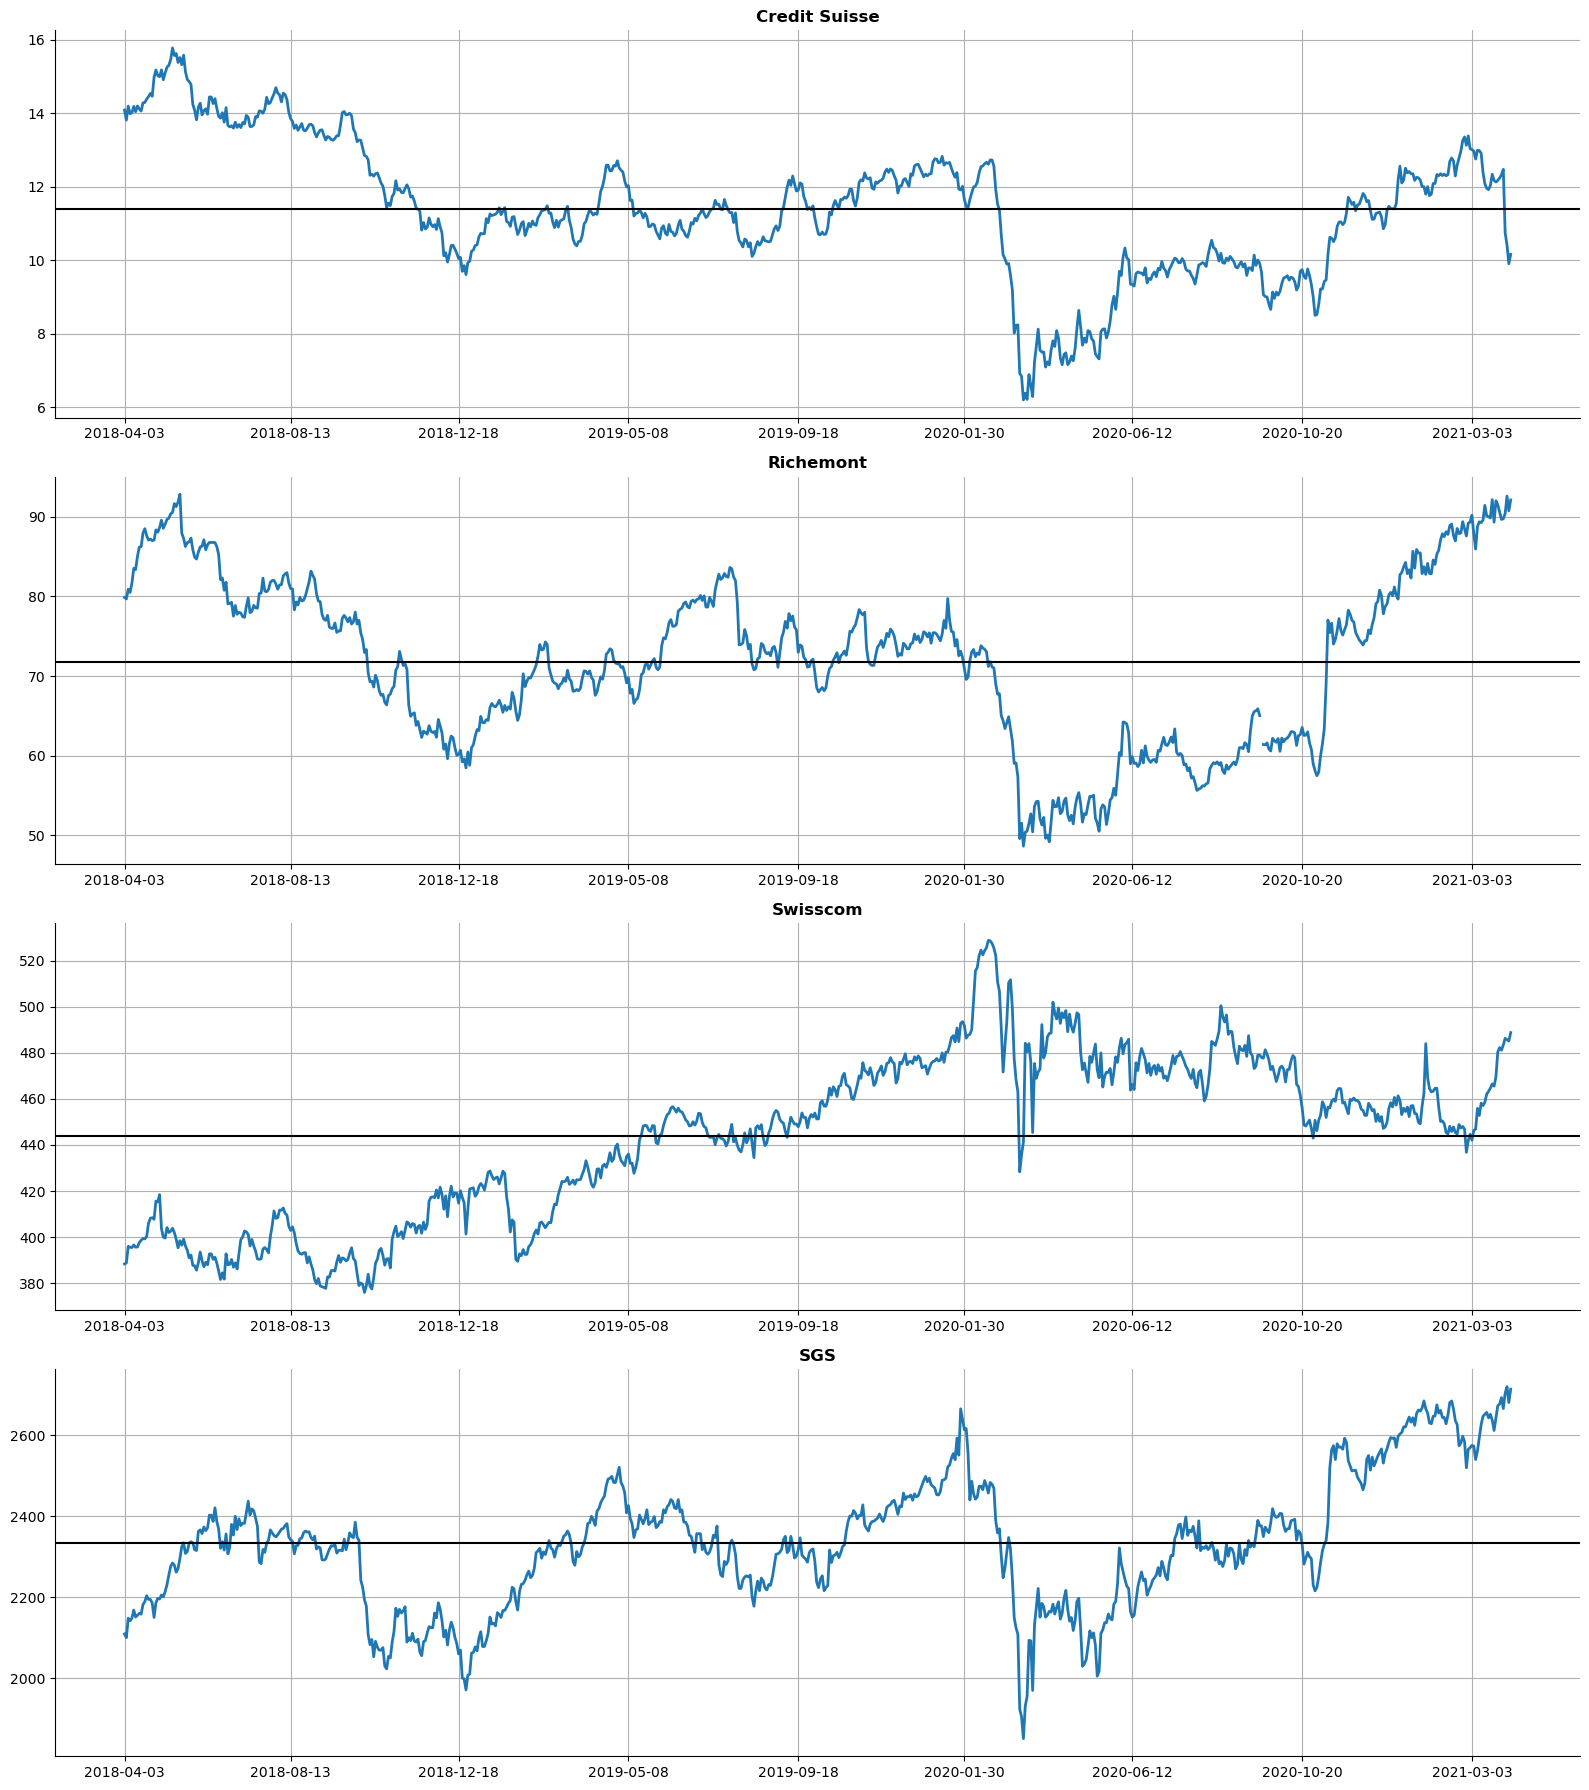

In [12]:
# Price
tcks = selected_prices.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_prices.iloc[:,i],lw=2)
    ax[i].axhline(selected_prices.iloc[:,i].mean(),c='k')
    ax[i].set_title(tcks[i],fontweight='bold')
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
#   ax[i].xaxis.set_major_formatter(mdates.DateLocator('%b %y'))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

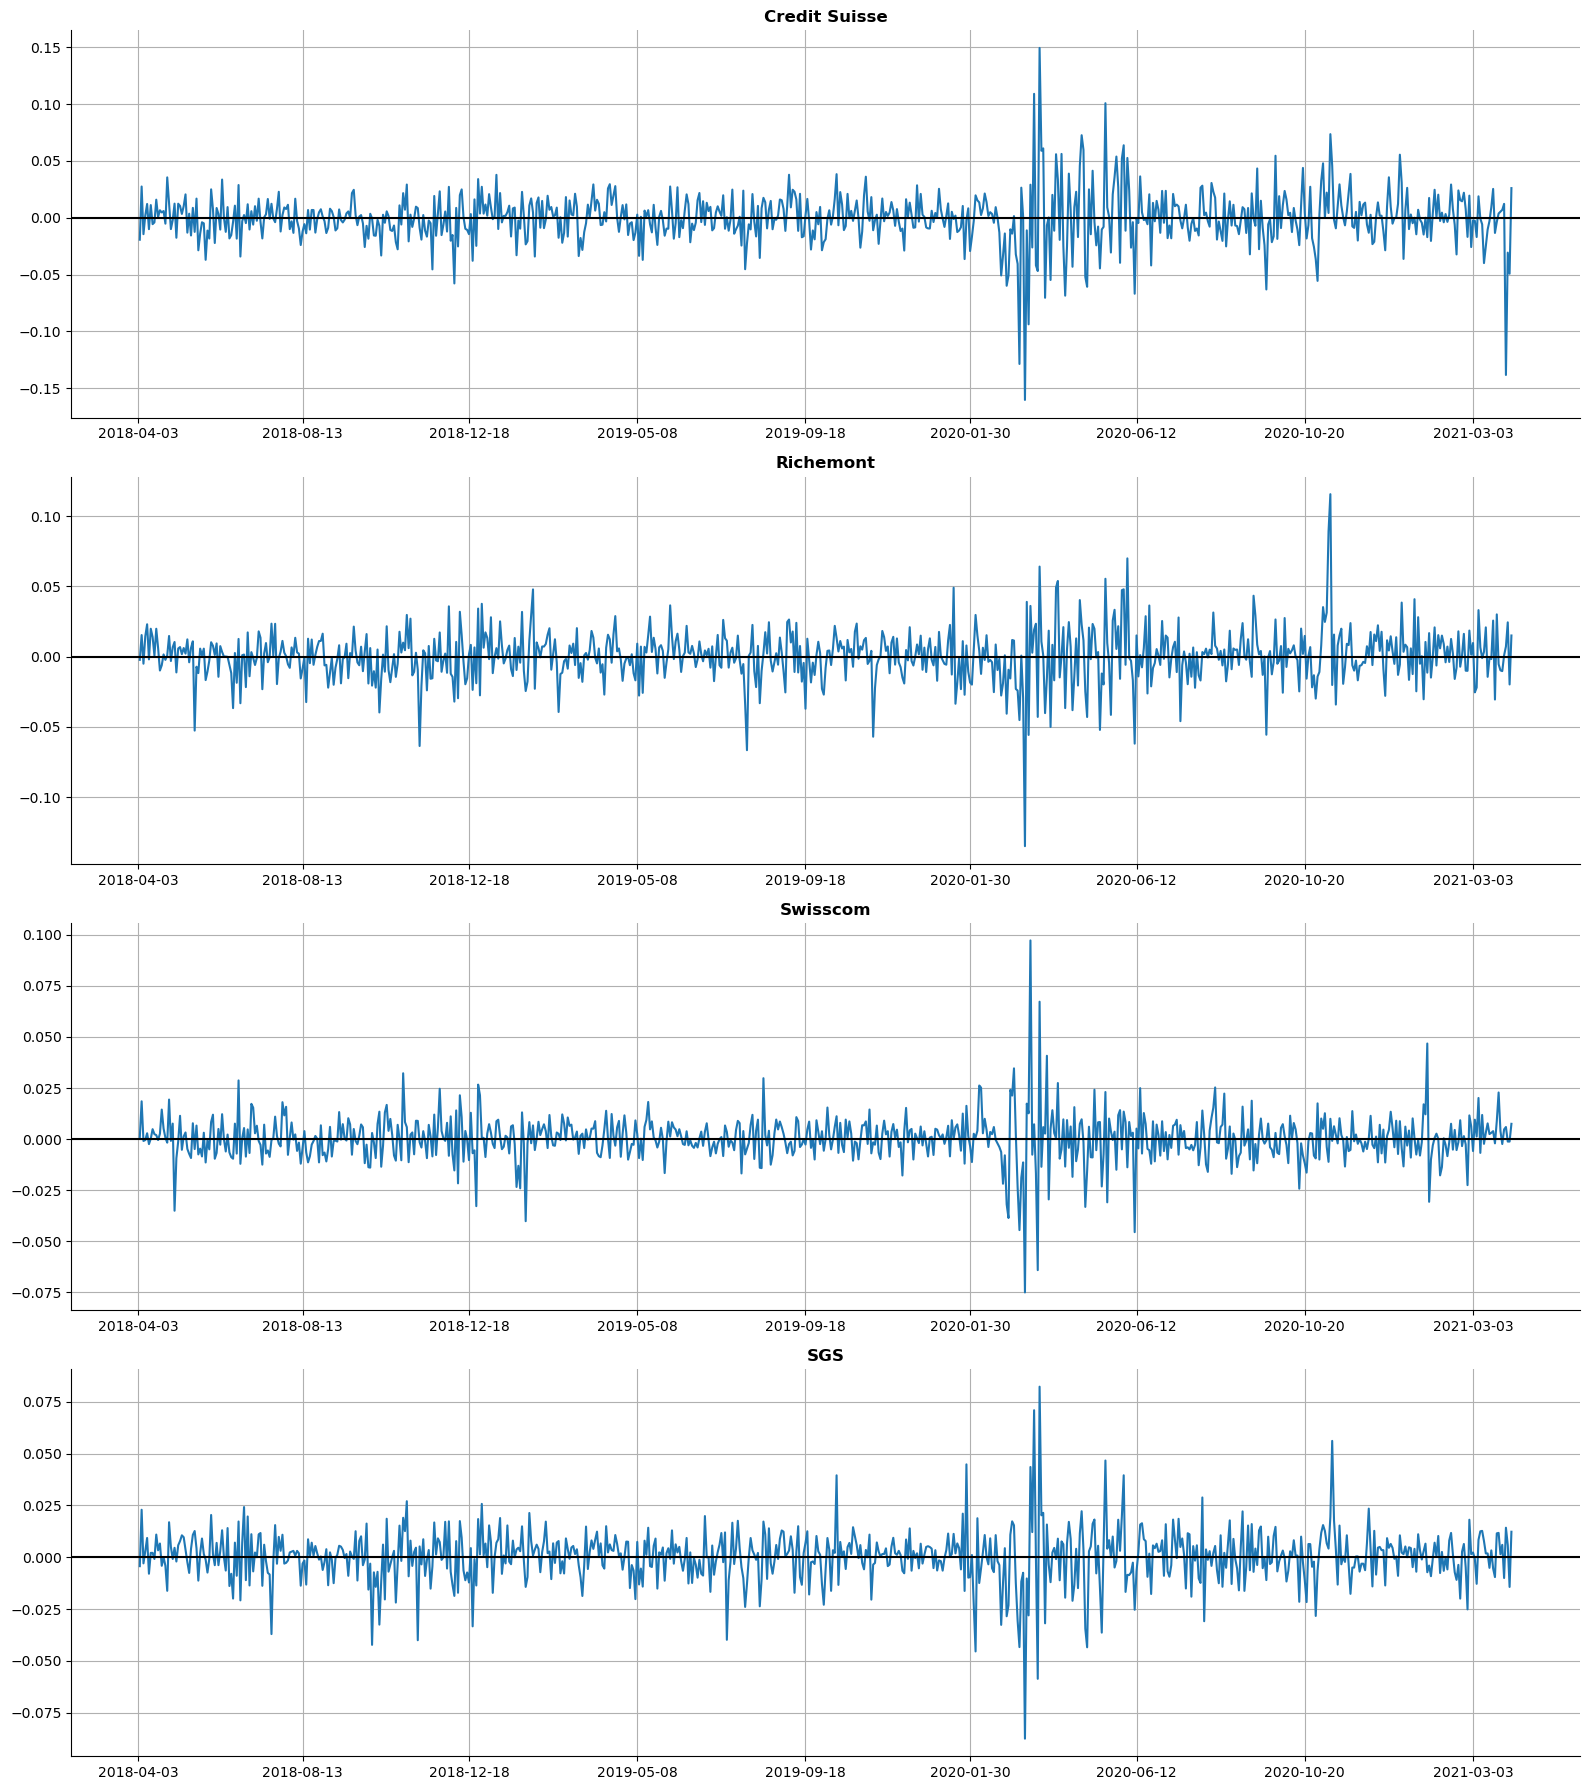

In [13]:
# Returns
tcks = selected_prices.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_returns.iloc[:,i])
    ax[i].axhline(y=0,c='k')
    ax[i].set_title(tcks[i],fontweight='bold')
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
#   ax[i].xaxis.set_major_formatter(mdates.DateLocator('%b %y'))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

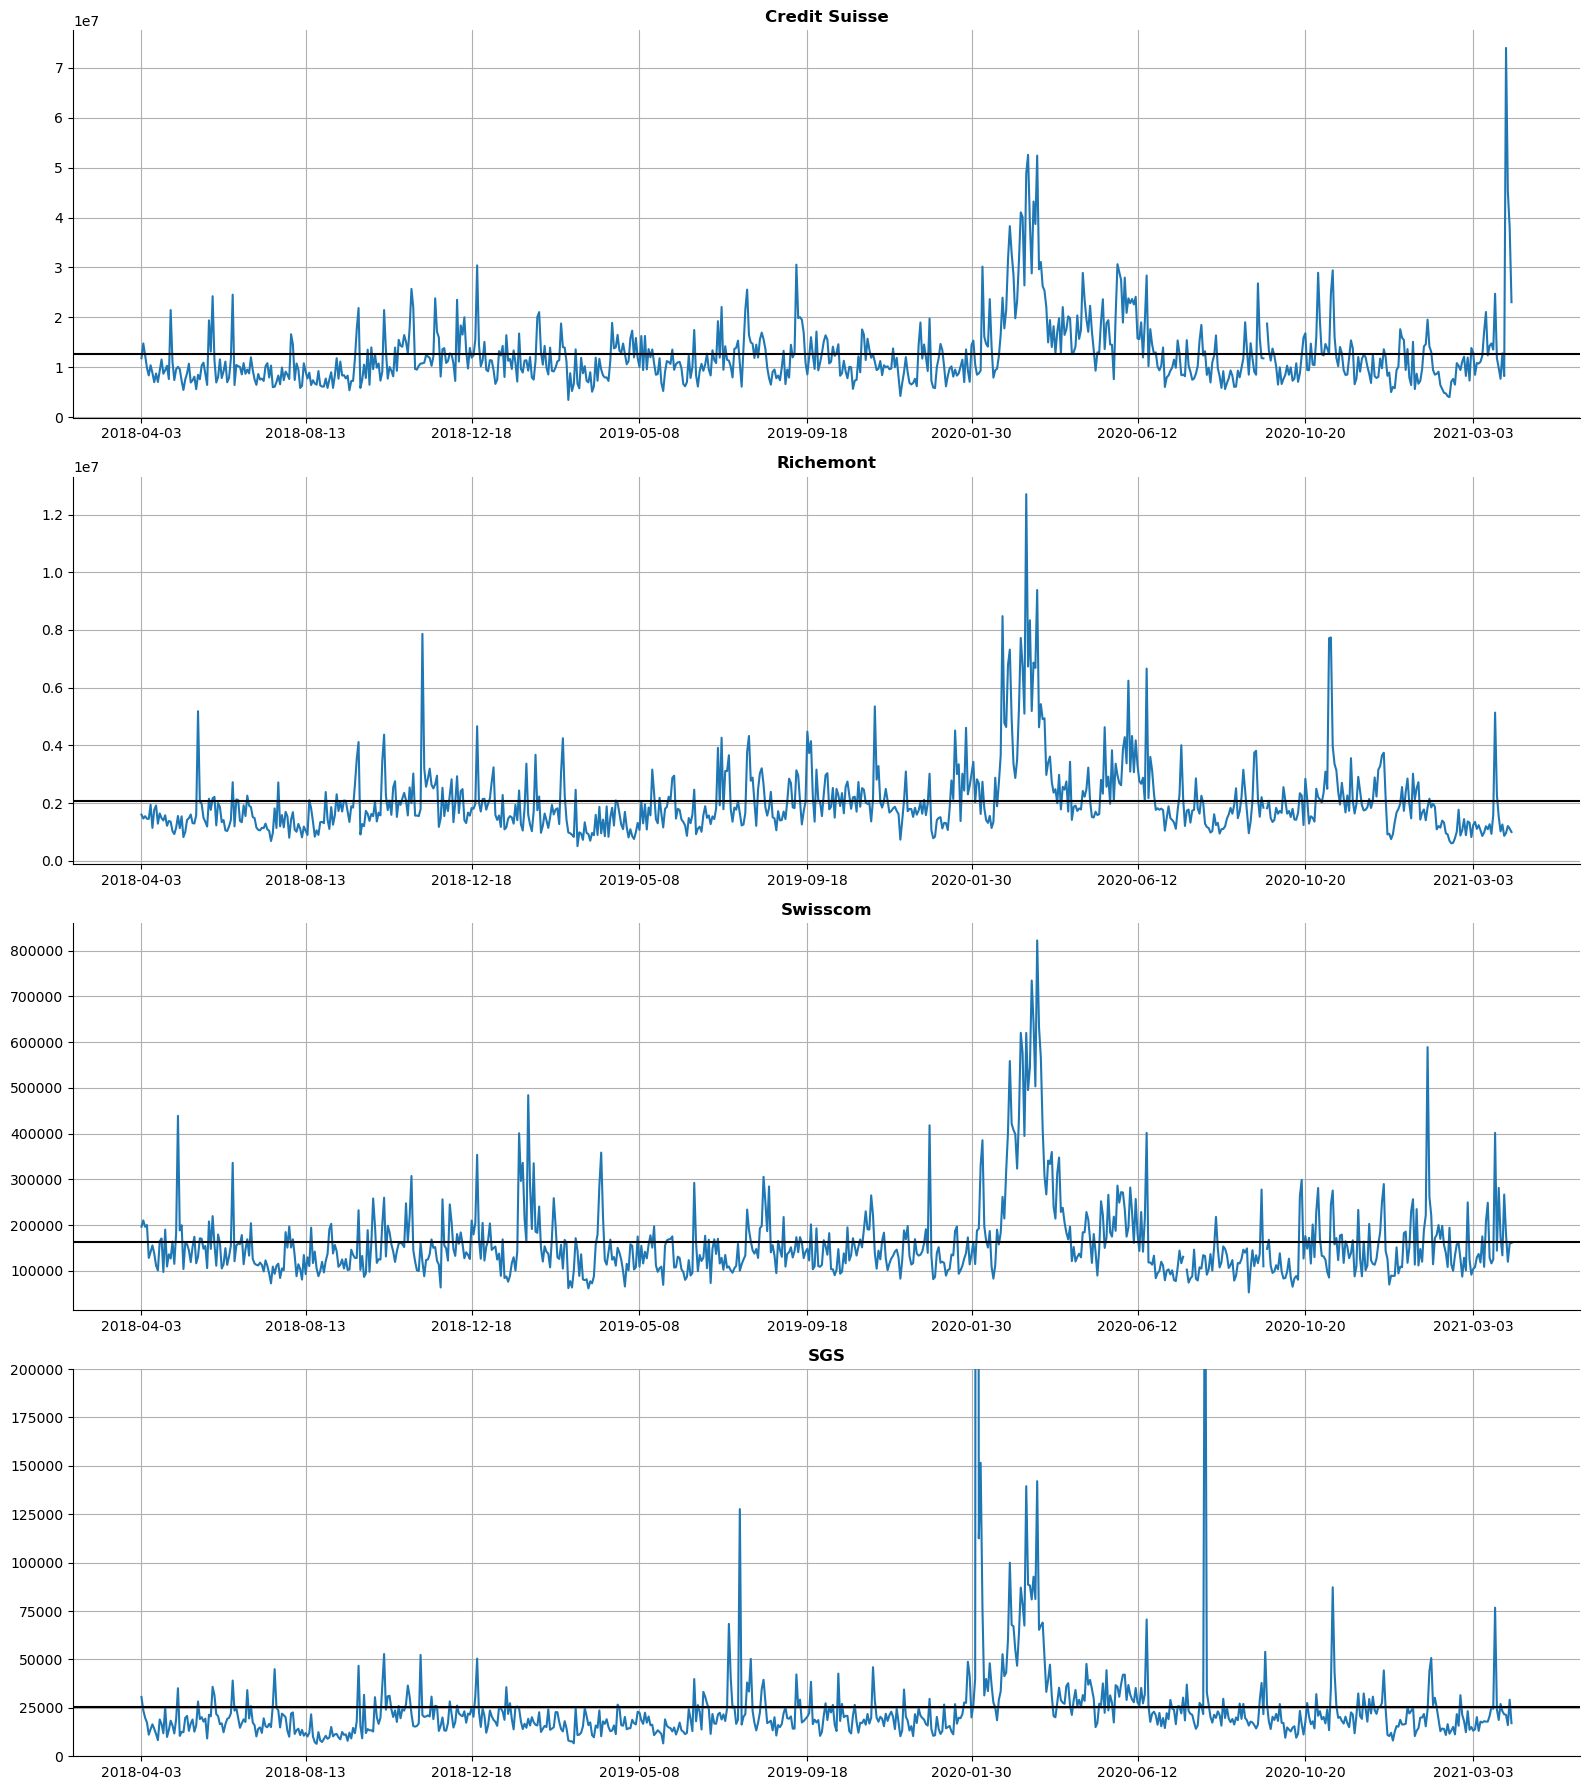

In [14]:
# Price
tcks = selected_vols.columns
fig, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_vols.iloc[:,i])
    ax[i].axhline(selected_vols.iloc[:,i].mean(),c='k')
    ax[i].set_title(tcks[i],fontweight='bold')
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[3].set_ylim([0,200000])
#   ax[i].xaxis.set_major_formatter(mdates.DateLocator('%b %y'))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

## Distribution of Returns

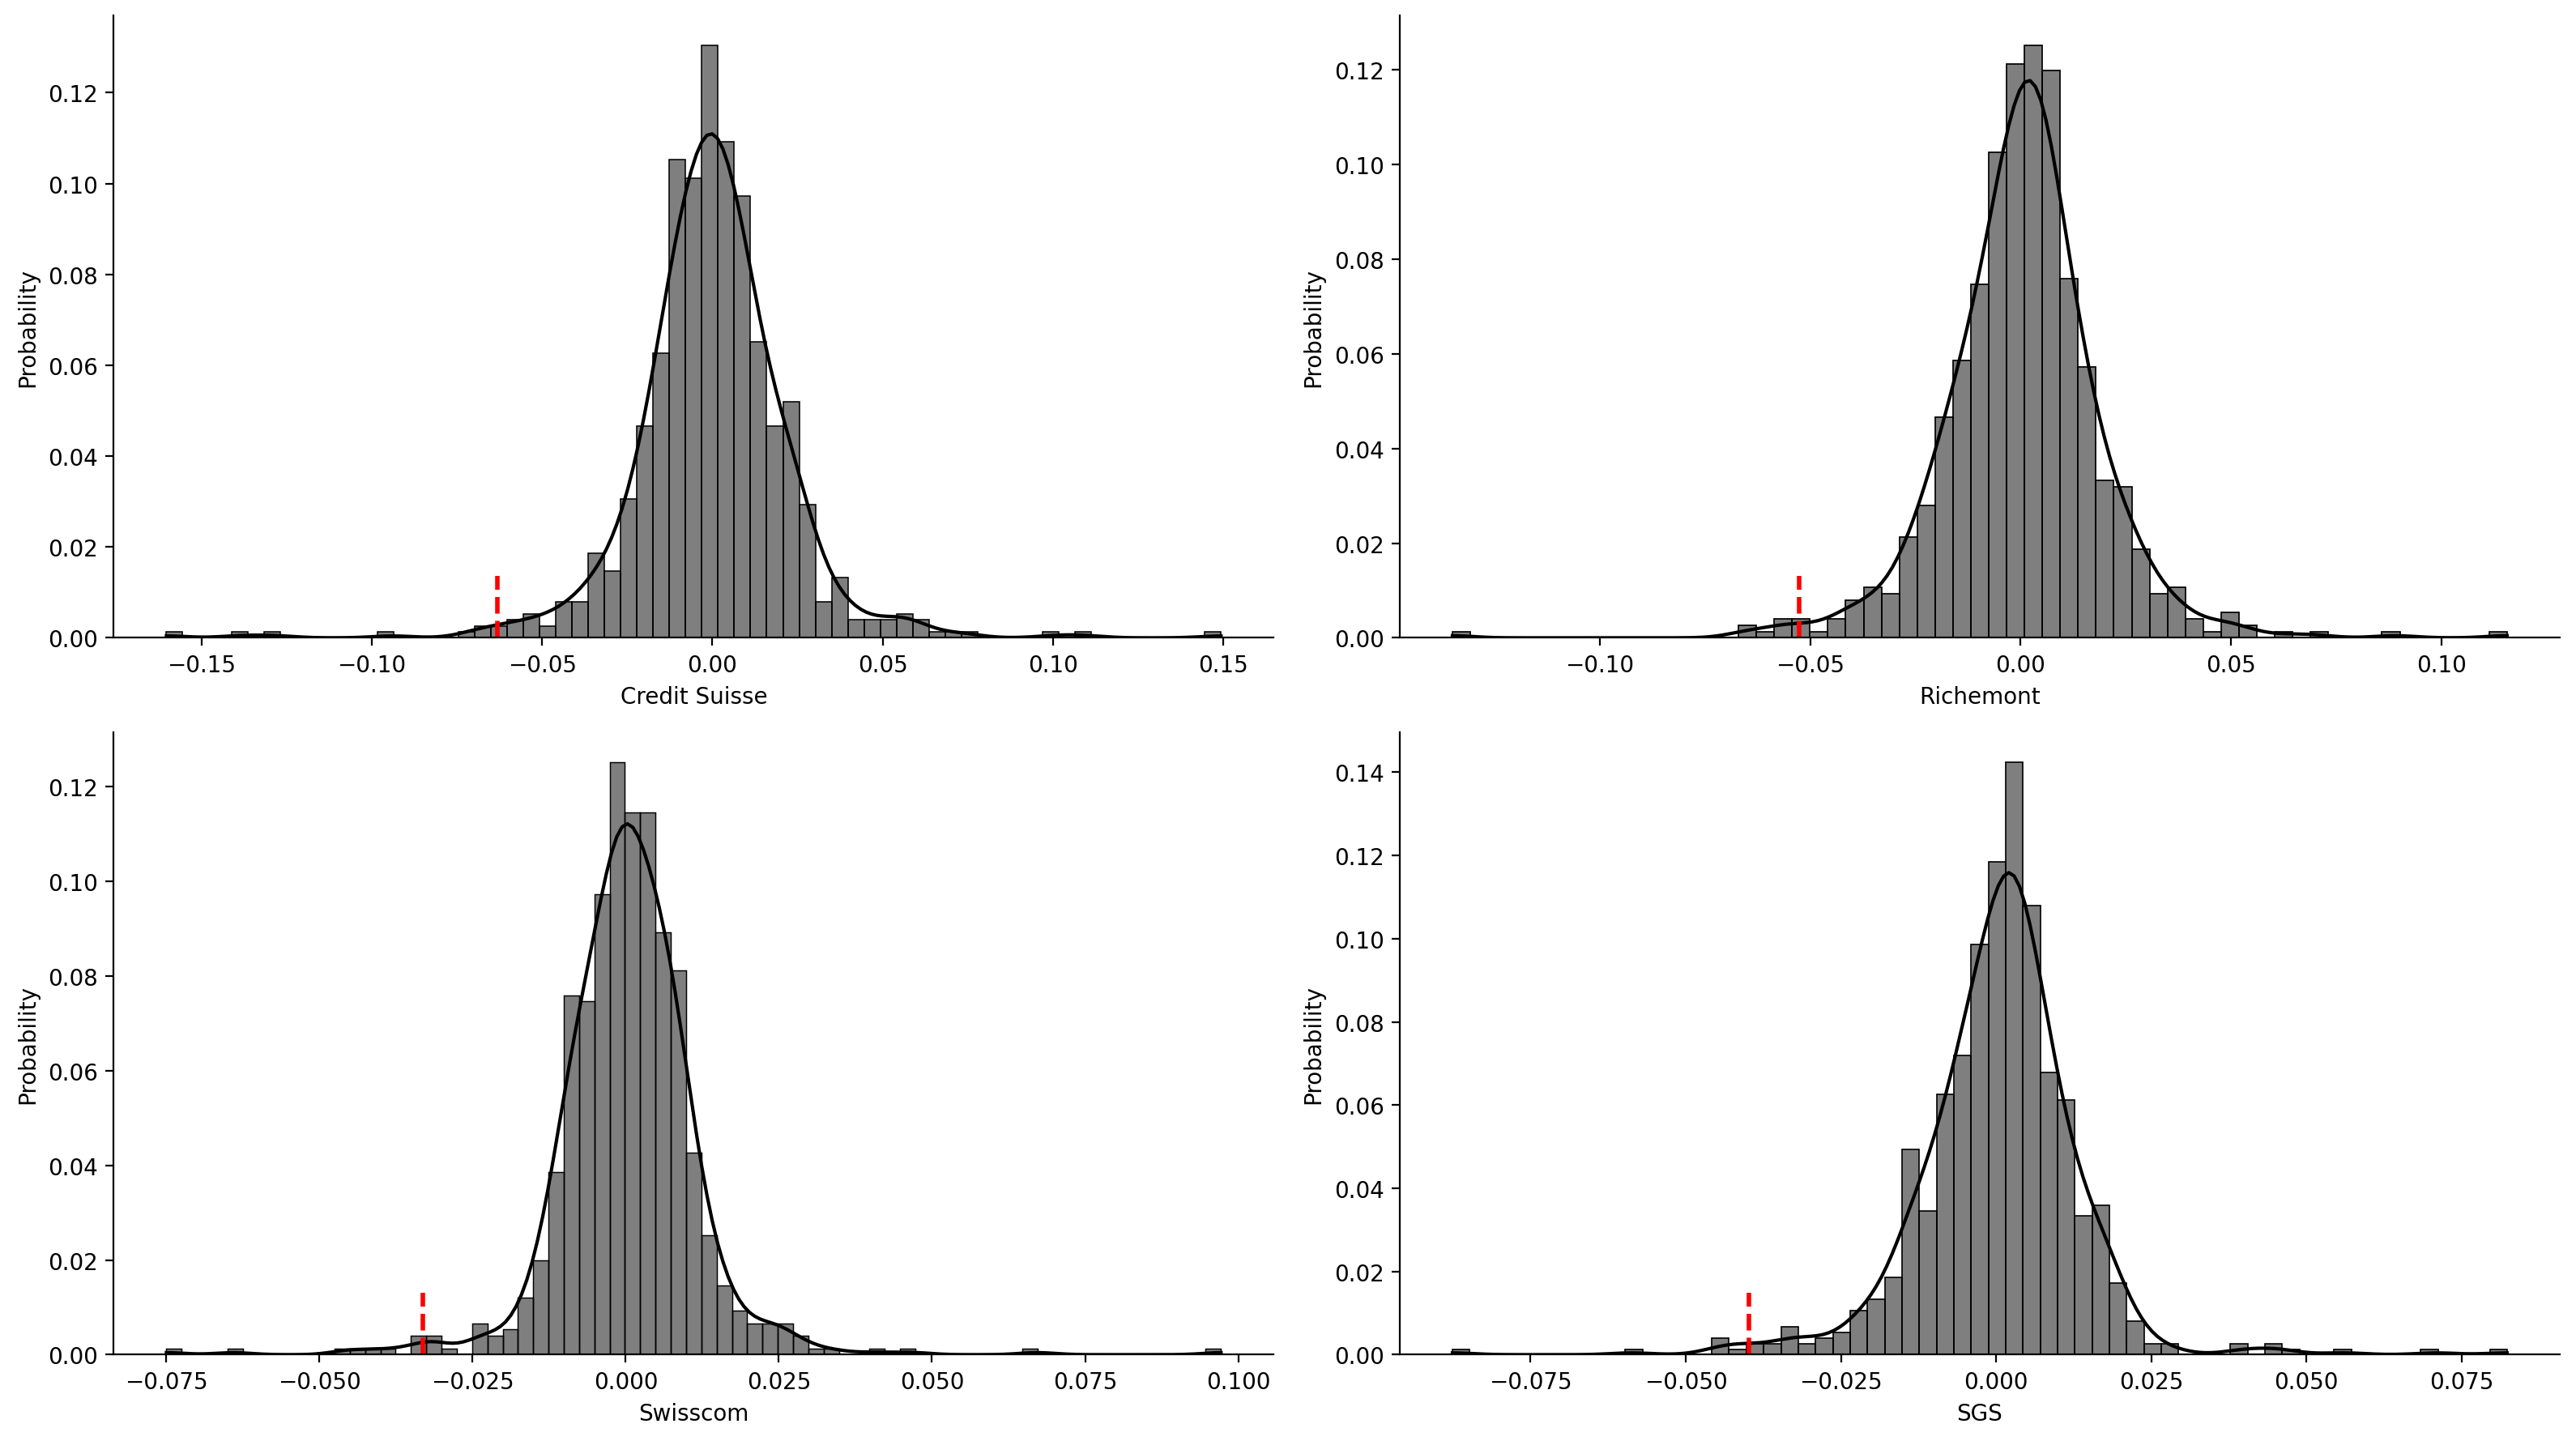

In [337]:
fig, ax = plt.subplots(2,2,figsize=[16,9],dpi=200)

sns.histplot(ax=ax[0,0],
             data=cs_rs,
             kde=True,
             stat='probability',
             color='k')
ax[0,0].axvline(-value_at_risk(cs_rs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[0,1],
             data=rich_rs,
             kde=True,
             stat='probability',
             color='k')
ax[0,1].axvline(-value_at_risk(rich_rs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,0],
             data=scom_rs,
             kde=True,
             stat='probability',
             color='k')
ax[1,0].axvline(-value_at_risk(scom_rs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,1],
             data=sgs_rs,
             kde=True,
             stat='probability',
             color='k')
ax[1,1].axvline(-value_at_risk(sgs_rs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.despine()
plt.tight_layout()

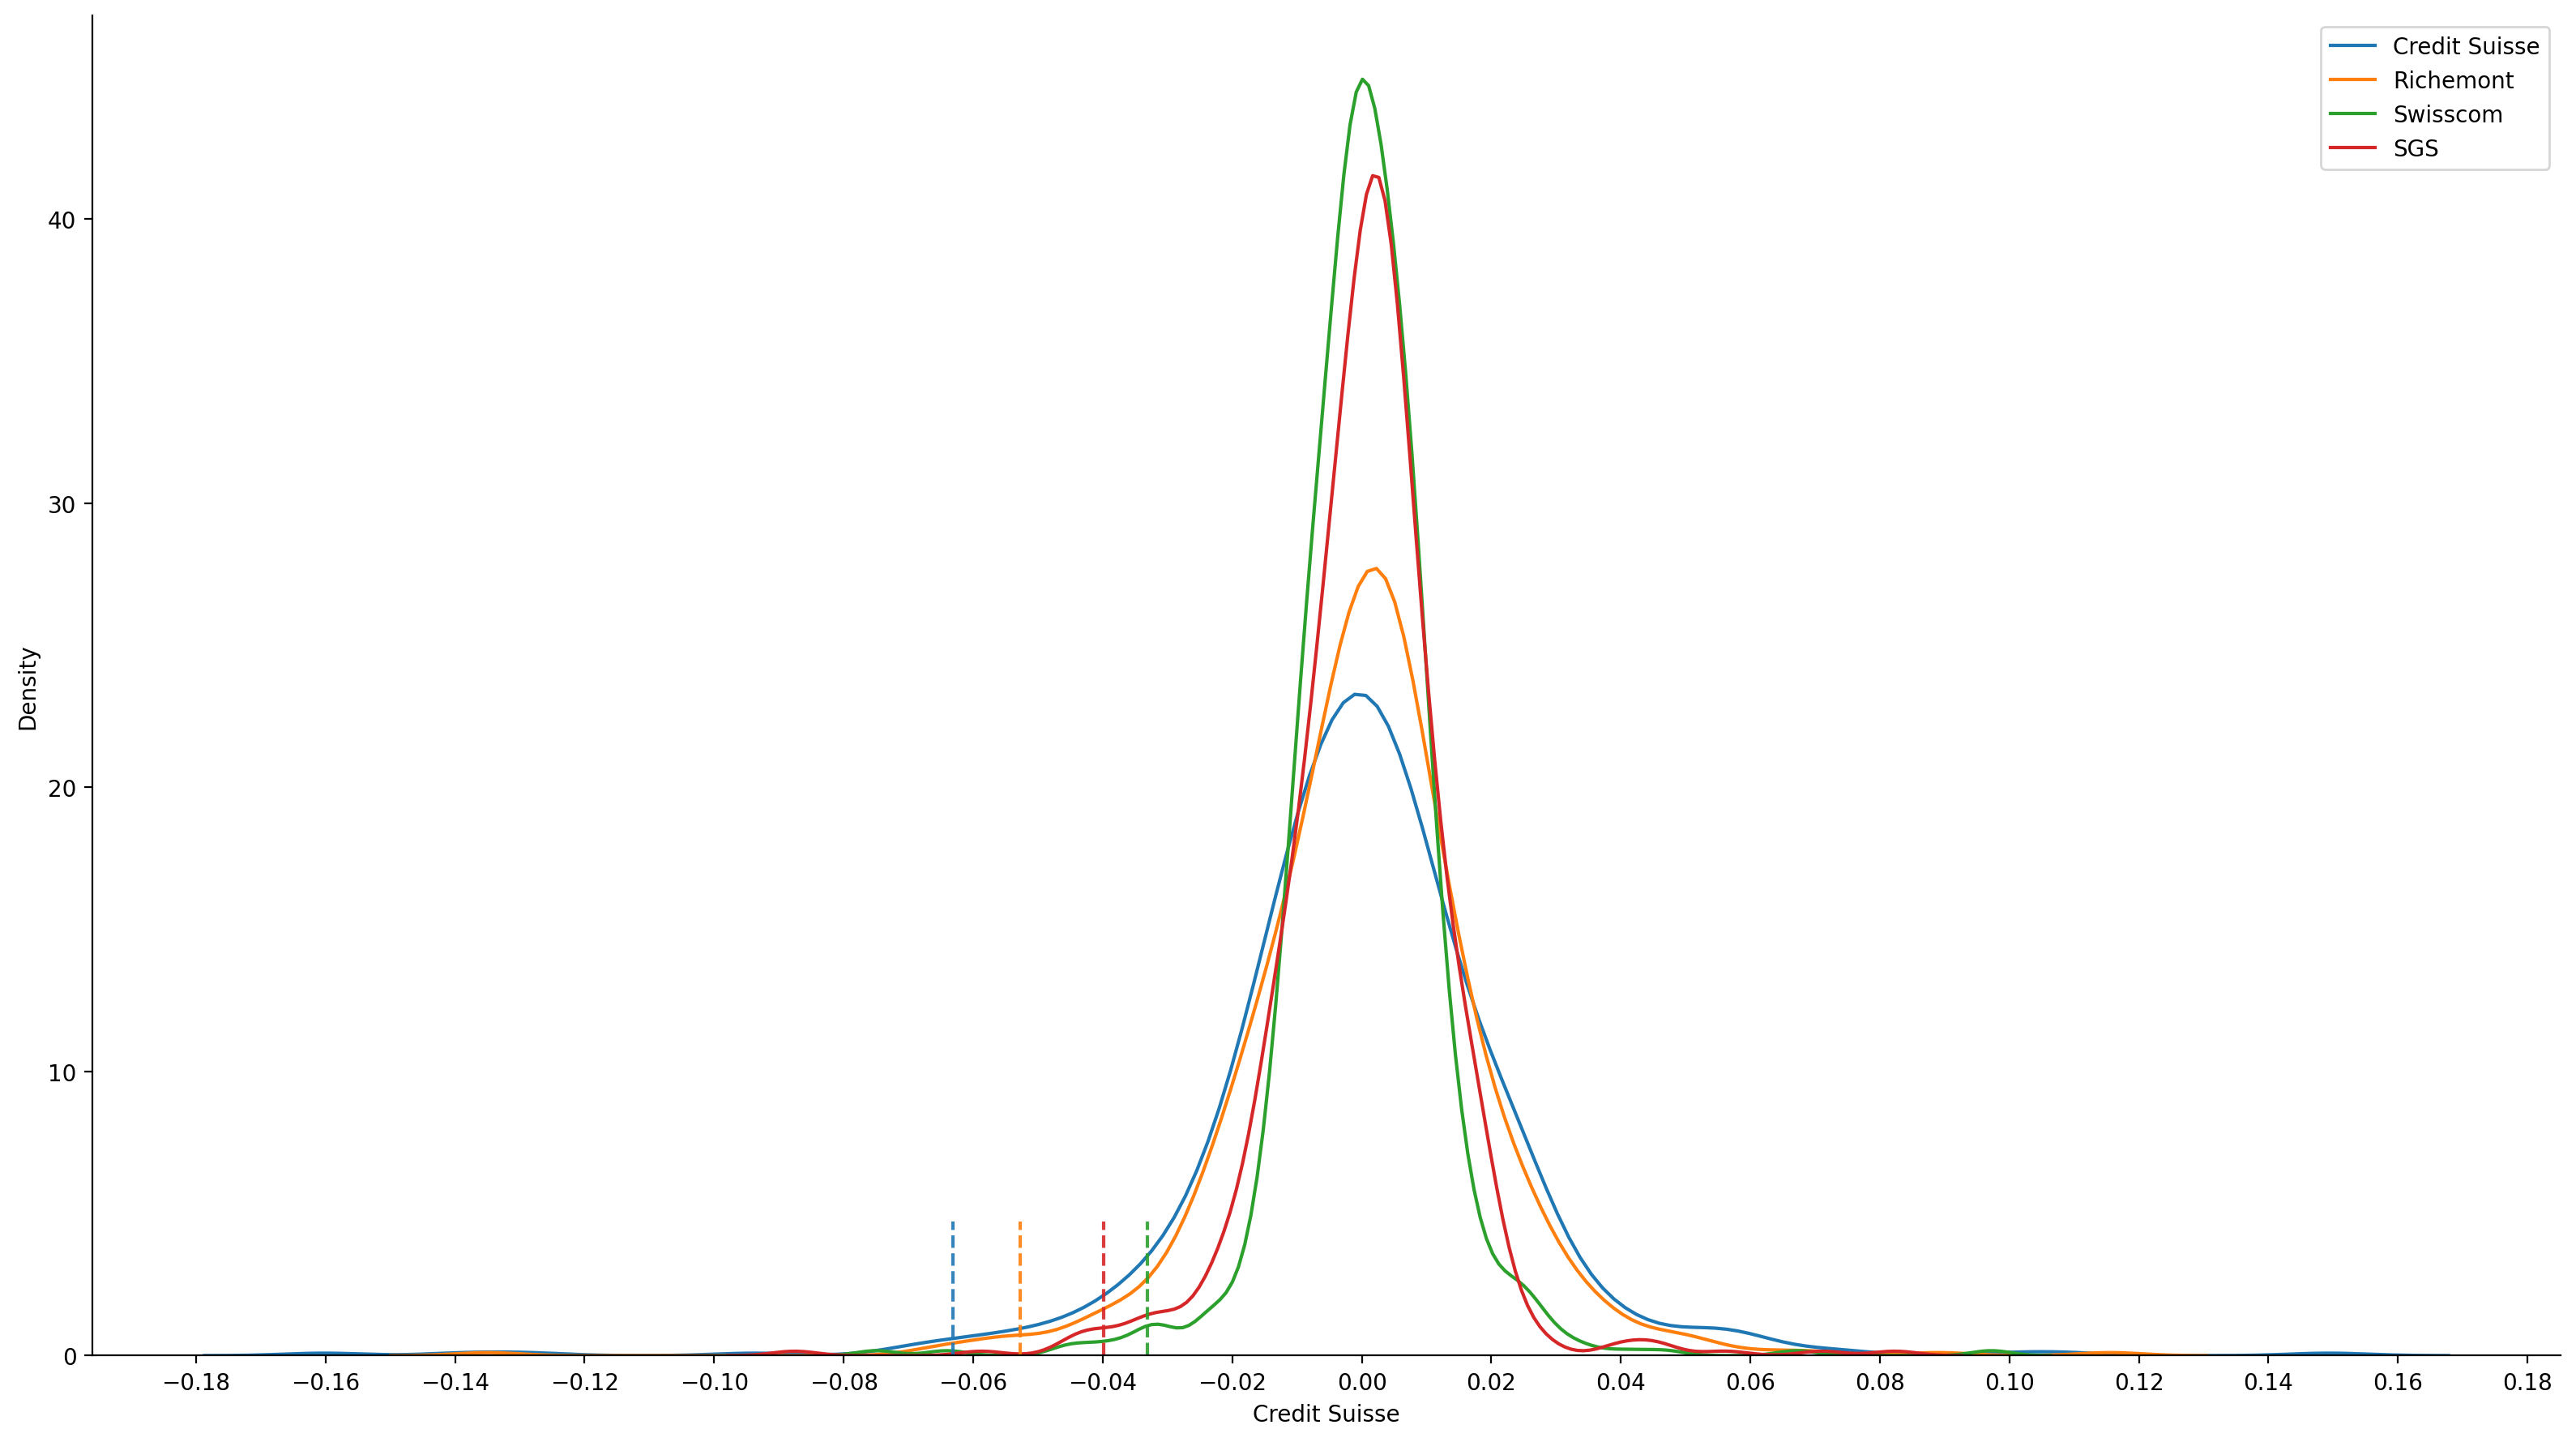

In [340]:
fig, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

sns.kdeplot(cs_rs)
sns.kdeplot(rich_rs)
sns.kdeplot(scom_rs)
sns.kdeplot(sgs_rs)

ax.axvline(-value_at_risk(cs_rs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C0',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(rich_rs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C1',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(scom_rs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C2',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(sgs_rs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C3',
           lw=1.5,alpha=0.9)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
#ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())


sns.despine()
plt.legend(selected_names)

plt.tight_layout()

## Systemic Risk

In [462]:
cs_p_newdates = cs_p.reindex(smi20_dates)
rich_p_newdates = rich_p.reindex(smi20_dates)
scom_p_newdates = scom_p.reindex(smi20_dates)
sgs_p_newdates = sgs_p.reindex(smi20_dates)

fig, ax = plt.subplots(1,ncols=1,
                       figsize=[16,9],dpi=100)
ax.plot(smi20_p - smi20_p.iloc[0,:])
ax.plot(cs_p_newdates - cs_p_newdates[0])
ax.plot(rich_p_newdates - rich_p_newdates[0])
ax.plot(scom_p_newdates - scom_p_newdates[0])
ax.plot(sgs_p_newdates - sgs_p_newdates[0])
ax.plot(cs_p - cs_p.iloc[0,:])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.tight_layout()

IndexingError: Too many indexers

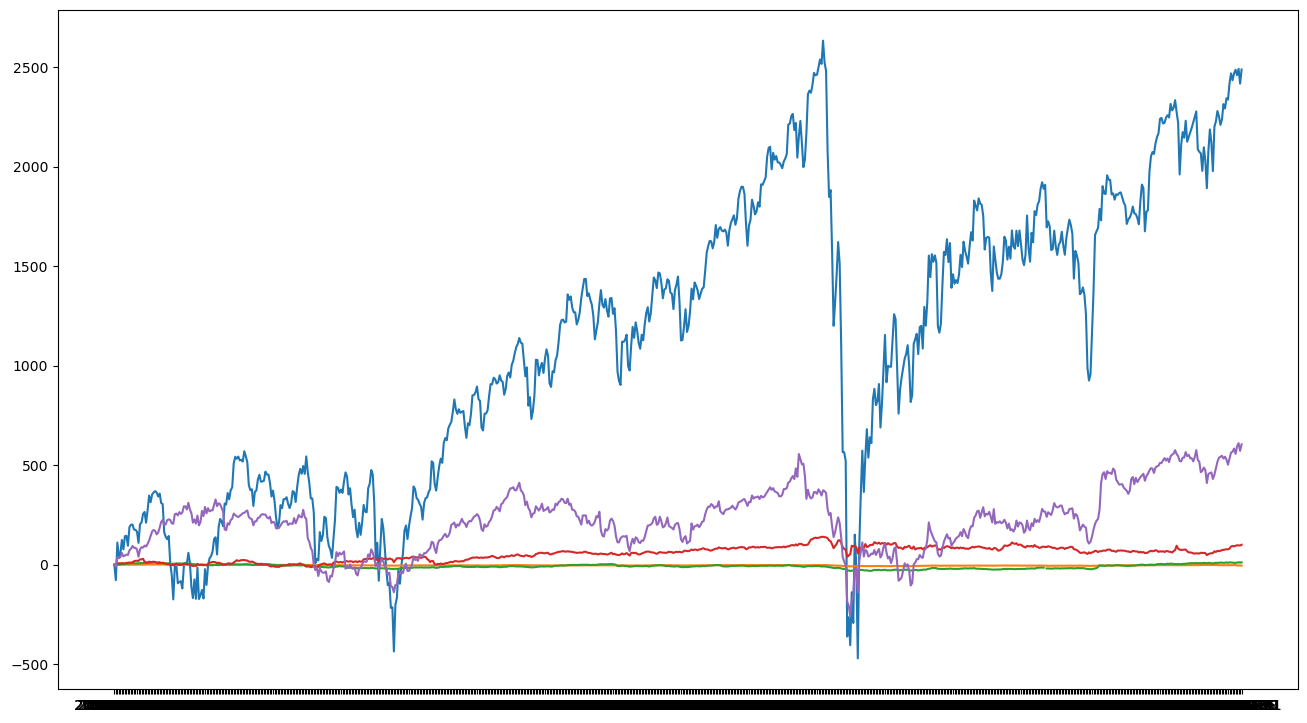

In [512]:
smi20_p.index = pd.to_datetime(smi20_p.index)
cs_p.index = pd.to_datetime(cs_p.index)
rich_p.index = pd.to_datetime(rich_p.index)
scom_p.index = pd.to_datetime(scom_p.index)
sgs_p.index = pd.to_datetime(sgs_p.index)

In [454]:
def reindex_monthly(series):
    return series.resample('BMS').first()
    
def reindex_weekly(series):
    return series.resample('W').first()

In [518]:
smi20_pM = reindex_monthly(smi20_p)

cs_pM = reindex_monthly(cs_p)
rich_pM = reindex_monthly(rich_p)
scom_pM = reindex_monthly(scom_p)
sgs_pM = reindex_monthly(sgs_p)

selected_pricesM = pd.concat([cs_pM,rich_pM,sgs_pM,sgs_pM],axis=1)

# ---

smi20_pW = reindex_weekly(smi20_p)

cs_pW = reindex_weekly(cs_p)
rich_pW = reindex_weekly(rich_p)
scom_ppW = reindex_weekly(scom_p)
sgs_pW = reindex_weekly(scom_p)

selected_pricesW = pd.concat([cs_pW,rich_pW,sgs_pW,sgs_pW],axis=1)

In [641]:
# def covar(x,y):
#     x = x.reindex(y.index)
#     x = np.array(x).reshape(len(x))
#     y = np.array(y).reshape(len(y))
#     n = len(x)
#     x_bar = mean(x)
#     y_bar = mean(y)
#     de_mean_x =  [x_i - x_bar for x_i in x]
#     de_mean_y = [y_i - y_bar for y_i in y]
#     return np.dot(de_mean_x,de_mean_y) / (n-1)

# def correlation(x,y):
#     x = np.array(x).reshape(len(x))
#     y = np.array(y).reshape(len(y))
#     n = len(x)
#     x_bar = mean(x)
#     y_bar = mean(y)
#     de_mean_x =  [x_i - x_bar for x_i in x]
#     de_mean_y = [y_i - y_bar for y_i in y]
    
#     cov = np.dot(de_mean_x,de_mean_y) / (n-1)
#     corr = cov / (std(x)*std(y)) 
    
#     return corr

In [637]:
def four_moments(equity_prices,market_prices):
    x = equity_prices.interpolate()
    y = market_prices
    
    # market price obs are less than equity price obs
    # so make those two equal
    x = x.reindex(y.index)
    
    x = np.array(x).reshape(len(x))
    y = np.array(y).reshape(len(y))
    
    de_mean_x = x - mean(x)
    de_mean_y = y - mean(y)
    
    cov = np.dot(de_mean_x,de_mean_y) / (n-1)
    corr = cov / (std(x)*std(y)) 
    
    cov2 =  np.dot(de_mean_x,de_mean_y**2) / (n-1)
    coskew = cov2 / (std(x)*std(y)**2)
    
    cov3 = np.dot(de_mean_x,de_mean_y**3) / (n-1)
    cokurt = cov3 / (std(x)*std(y)**3)
    return corr, coskew, cokurt

In [638]:
moments = []
for i in range(4):
    fm = four_moments(selected_prices.iloc[:,i],smi20_p)
    moments.append(fm)
pd.DataFrame(moments,index=selected_names,columns=['Correlation','Coskewness','Cokurtosis']).round(2)

,Correlation,Coskewness,Cokurtosis
Credit Suisse,-0.16,0.32,-0.05
Richemont,0.10,0.33,0.45
Swisscom,0.79,-0.13,1.37
SGS,0.72,0.17,1.52


In [640]:
# moments = []
# for i in range(4):
#     fm = four_moments(selected_returns.iloc[:,i],smi20_rs)
#     moments.append(fm)
# pd.DataFrame(moments,index=selected_names,columns=['Correlation','Coskewness','Cokurtosis']).round(2)

In [644]:
value_at_risk(cs_rs,alpha)

0.06311271725555123

In [647]:
ll = []
for i in range(20,len(cs_rs)):
    a = value_at_risk(cs_rs.iloc[20:20+i],alpha)
    ll.append(a)
ll = pd.Series(ll,index=cs_rs.index[20:])
ll

Date
2018-05-02    0.037026
2018-05-03    0.037026
2018-05-04    0.037026
2018-05-07    0.037026
2018-05-08    0.037026
                ...   
2021-03-26    0.063113
2021-03-29    0.063113
2021-03-30    0.063113
2021-03-31    0.063113
2021-04-01    0.063113
Length: 732, dtype: float64

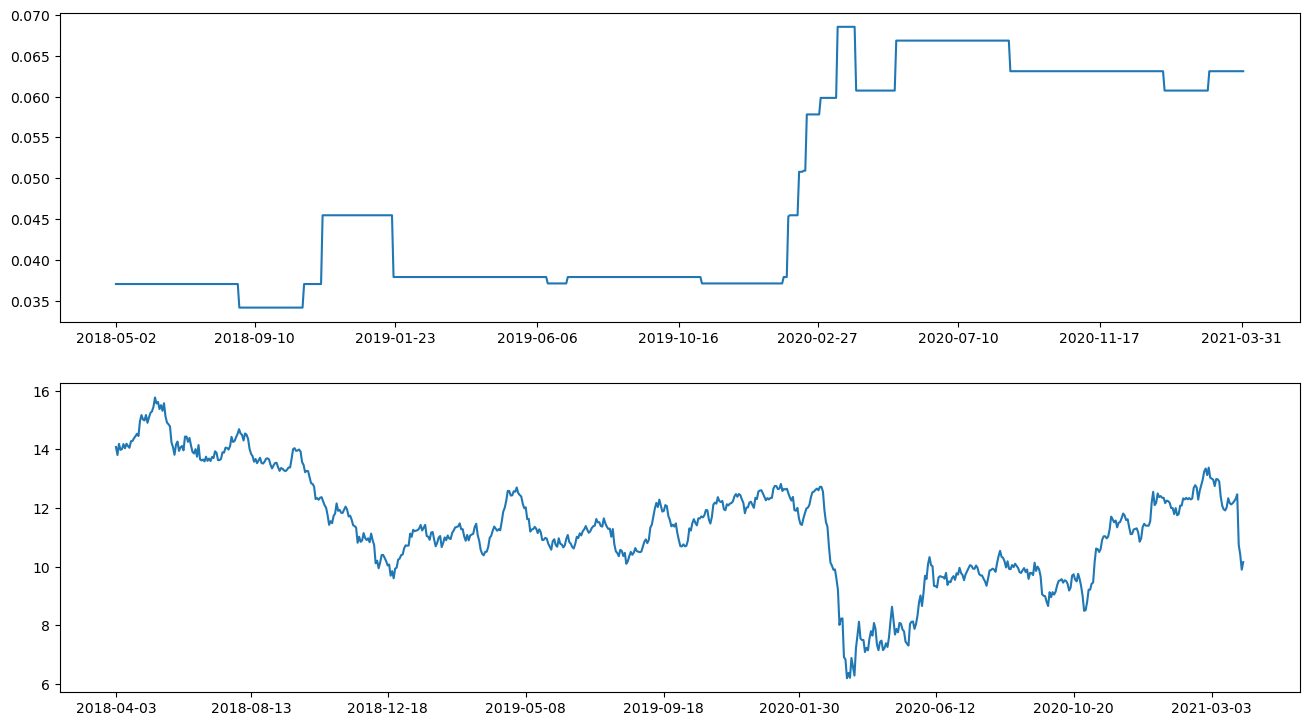

In [648]:
fig, ax = plt.subplots(2,1,figsize=[16,9],dpi=100)
ax[0].plot(ll)
ax[0].xaxis.set_major_locator(mdates.AutoDateLocator())
ax[1].plot(smi_prices['Credit Suisse'])
ax[1].xaxis.set_major_locator(mdates.AutoDateLocator())